In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [4]:
PATH_DATA='../data/raw/'
PATH_DATA_INTERIM='../data/interim/'

In [5]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter1_interim_cln.csv')

In [6]:
df1.sample()

,id,time,street,median_length,median_delay,median_speed_kmh,total_records,level,time2,hours,...,streettime2,is_train,weekendmean,weekendstd,weekdaysmean,weekdaysstd,weekdaysmean69,weekdaysstd69,weekdaysmean1518,weekdaysstd1518
65689,35972095,2022-08-14 16:00:00.000,Atang Sanjaya,717.0,378.0,5.38,4,3,2022-08-14 16:00:00,16,...,Atang Sanjaya_2022-08-14 16:00:00.000,1,2.185185,1.110684,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## we use 1 as turn over
col_used = list(set(df1.columns)-set(['id','is_train','level','time','time2','street','streettime','streettime2']))

col_used.sort() ## --> remember to sort

In [8]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['level']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['level']

In [9]:
Ytrain.mean(), Ytest.mean()

(2.4188851447968864, 2.429523525315826)

Transformation

In [10]:
SS = StandardScaler()

In [11]:
SS.fit(Xtrain)
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Ytrain = le.fit_transform(Ytrain)
Ytest = le.fit_transform(Ytest)

In [13]:
#store data, all in numpy arrays
training_data = {'X_train':Xtrain_ss,'Y_train':Ytrain,
                'X_test': Xtest_ss,'Y_test':Ytest}

In [14]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [33]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=11,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    reg_alpha=1e-5,
                    nthread=4,
                    num_class=5,
                    seed=27)

xgb1.fit(training_data['X_train'], training_data['Y_train'])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_class=5,
              num_parallel_tree=None, ...)

In [34]:
predicted_labels = xgb1.predict(training_data['X_test'])
accuracy_score(training_data['Y_test'], predicted_labels)

0.8642693723266687

In [35]:
params = {  'n_estimators':[1000],
            'max_depth':[11,12,13],
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = params, scoring='f1_micro',n_jobs=3,verbose = 10, cv=5)
gsearch1.fit(training_data['X_train'], training_data['Y_train'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=11,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None, nthread=4,
                                     num_class=5, num_parallel_tree=None, ...),
             n_jobs=3,
             param_grid={'max_depth': [11, 12, 13], 'n_estimators': [1000]},
             scoring='f1_micro', verbose=10)

In [36]:
print(getTrainScores(gsearch1))

({0: "mean:0.8819614578637781params{'max_depth': 11, 'n_estimators': 1000}", 1: "mean:0.8805812521254401params{'max_depth': 12, 'n_estimators': 1000}", 2: "mean:0.8806310226919489params{'max_depth': 13, 'n_estimators': 1000}"}, {'best_mean': 0.8819614578637781, 'best_param': {'max_depth': 11, 'n_estimators': 1000}})


In [37]:
xgb2 = gsearch1.best_estimator_
xgb2.fit(training_data['X_train'], training_data['Y_train'])
predicted_labels =xgb2.predict(training_data['X_test'])
train_pred = xgb2.predict(training_data['X_train'])
print('Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('------')
print('Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))

Train Accuracy:1.0
Train F1-Score(Micro):1.0
------
Test Accuracy:0.8642693723266687
Test F1-Score(Micro):0.8642693723266687


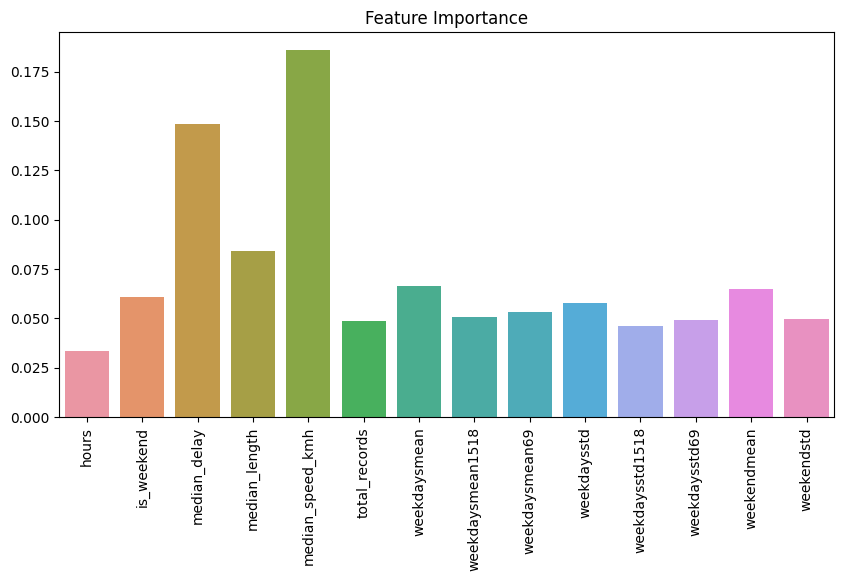

In [38]:
features = Xtest_ss.columns
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [39]:
print('Classification report:\n', classification_report(training_data['Y_test'], predicted_labels))
conf_mat = confusion_matrix(training_data['Y_test'], predicted_labels)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      3891
           1       0.86      0.86      0.86      7080
           2       0.88      0.86      0.87      6072
           3       0.90      0.87      0.89      2734
           4       1.00      1.00      1.00       329

    accuracy                           0.86     20106
   macro avg       0.89      0.89      0.89     20106
weighted avg       0.86      0.86      0.86     20106

Confusion matrix:
 [[3387  484   15    5    0]
 [ 550 6072  448   10    0]
 [ 109  523 5202  238    0]
 [  58   18  271 2387    0]
 [   0    0    0    0  329]]
